# HateScore 혐오 표현 분석

## 개요
- **분석 방법**: 딥러닝 기반 (HateScore Model)
- **분석 대상**: 유튜브 연애 클립 댓글
- **분류 카테고리**: 10가지 혐오 유형 (여성, LGBTQ+, 남성, 인종, 지역, 종교, 연령, 기타 혐오, 욕설, 중립)

## 데이터 소스
- 댓글 레벨: `output/results/hatescore/comments_with_hatescore.csv`
- 동영상 요약: `output/results/hatescore/video_summary_hatescore.csv`
- 프로그램 요약: `output/results/hatescore/program_summary_hatescore.csv`
- 전체 요약: `output/results/hatescore/overall_summary_hatescore.json`

✓ 라이브러리 로드 완료
✓ font.family      : ['sans-serif']
✓ font.sans-serif  : ['Nanum Gothic', 'NanumGothic', 'AppleGothic']


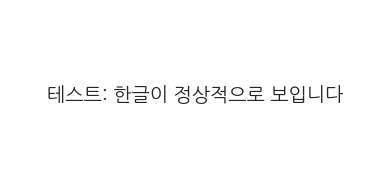

In [24]:
# =========================
# Visualization Environment Setup
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import json
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# -------------------------
# Seaborn style (FIRST)
# -------------------------
sns.set_style('whitegrid')
sns.set_palette('husl')

# -------------------------
# Font (Korean-safe, seaborn-compatible)
# -------------------------
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [
        'Nanum Gothic',
        'NanumGothic',
        'AppleGothic',
        'Malgun Gothic',
        'DejaVu Sans'
    ],
    'axes.unicode_minus': False
})

# -------------------------
# Figure defaults
# -------------------------
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# -------------------------
# Global color scheme
# -------------------------
SENTIMENT_COLORS = {
    'positive': '#4CAF50',  # green
    'negative': '#F44336',  # red
    'neutral':  '#9E9E9E'   # gray
}

HATE_COLORS = {
    'hate': '#F44336',      # 빨강 (혐오)
    'normal': '#4CAF50',    # 초록 (일반)
    'warning': '#FF9800',   # 주황 (주의)
    'danger': '#D32F2F'     # 진한 빨강 (위험)
}

print("✓ 라이브러리 로드 완료")
print(f"✓ font.family      : {plt.rcParams['font.family']}")
print(f"✓ font.sans-serif  : {plt.rcParams['font.sans-serif'][:3]}")

# -------------------------
# Font sanity check
# -------------------------
fig, ax = plt.subplots(figsize=(4, 2))
ax.text(
    0.5, 0.5,
    '테스트: 한글이 정상적으로 보입니다',
    ha='center', va='center', fontsize=14
)
ax.axis('off')
plt.tight_layout()
plt.show()

## 1. 데이터 로드

In [25]:
# 전체 요약 통계 로드
with open('../output/results/hatescore/overall_summary_hatescore.json', 'r', encoding='utf-8') as f:
    overall = json.load(f)

print("=" * 70)
print("📊 전체 통계 (HateScore 혐오 표현 분석)")
print("=" * 70)
print(f"총 댓글 수: {overall['total_comments']:,}")
print(f"총 동영상 수: {overall['total_videos']}")
print(f"총 프로그램 수: {overall['total_programs']}")
print()
print(f"혐오 댓글 수: {overall['hate_count']:,} ({overall['hate_ratio']:.1%})")
print(f"평균 혐오 점수: {overall['avg_hate_score']:.3f}")
print(f"최대 혐오 점수: {overall['max_hate_score']:.3f}")

📊 전체 통계 (HateScore 혐오 표현 분석)
총 댓글 수: 156,655
총 동영상 수: 342
총 프로그램 수: 36

혐오 댓글 수: 152,518 (97.4%)
평균 혐오 점수: 0.924
최대 혐오 점수: 0.989


In [26]:
# 프로그램별 요약 로드
program_df = pd.read_csv('../output/results/hatescore/program_summary_hatescore.csv', encoding='utf-8')
print(f"✓ 프로그램 수: {len(program_df)}")
program_df.head()

✓ 프로그램 수: 36


,program,video_count,total_comments,total_hate_count,avg_hate_ratio,avg_hate_score,avg_prob_None,avg_prob_기타 혐오,avg_prob_남성,avg_prob_단순 악플,avg_prob_성소수자,avg_prob_여성/가족,avg_prob_연령,avg_prob_인종/국적,avg_prob_종교,avg_prob_지역
0,1920,10,2195,2167,0.985652,0.943764,0.932102,0.009742,0.006470,0.029953,0.005384,0.019746,0.003296,0.007085,0.003966,0.003651
1,2억9천결혼전쟁,9,593,586,0.992105,0.947168,0.938031,0.009706,0.005268,0.027891,0.005553,0.025146,0.003493,0.007725,0.003908,0.003804
2,나는솔로 12~17,10,5036,4891,0.972469,0.915442,0.882045,0.012919,0.010959,0.034219,0.008165,0.049694,0.005540,0.008998,0.009253,0.006082
3,나는솔로 18~23,10,2549,2468,0.970417,0.908062,0.884440,0.013270,0.009899,0.030618,0.009028,0.049567,0.004591,0.008769,0.005036,0.005513
4,나는솔로 1~4,10,3443,3338,0.970554,0.910318,0.867915,0.012983,0.014799,0.027882,0.008214,0.077401,0.005700,0.008136,0.004729,0.005694


In [27]:
# 동영상별 요약 로드
video_df = pd.read_csv('../output/results/hatescore/video_summary_hatescore.csv', encoding='utf-8')
print(f"✓ 동영상 수: {len(video_df)}")
video_df.head()

✓ 동영상 수: 342


,video_id,total_comments,hate_count,hate_ratio,avg_hate_score,max_hate_score,avg_prob_None,avg_prob_기타 혐오,avg_prob_남성,avg_prob_단순 악플,avg_prob_성소수자,avg_prob_여성/가족,avg_prob_연령,avg_prob_인종/국적,avg_prob_종교,avg_prob_지역,program,video_title
0,-6lrTnCu_p4,66,65,0.984848,0.917398,0.988061,0.861461,0.014644,0.010310,0.043796,0.007561,0.045139,0.038475,0.006995,0.004931,0.004140,돌싱글즈1~2,[돌싱글즈] 혹시 사별은 없으시죠? 돌싱남녀의 선 넘는 토크 EP01_#2 MBN...
1,-_dH9Bx9D_s,834,822,0.985612,0.930716,0.988360,0.912111,0.011426,0.007839,0.027611,0.006843,0.039160,0.003658,0.007694,0.004897,0.004534,모태솔로지만 연애는 하고 싶어,"0.5에서 1까지, 여명만의 플러팅 공식ㅣ모태솔로지만 연애는 하고 싶어ㅣ넷플릭스"
2,-orGRTtOISE,554,553,0.998195,0.959992,0.987670,0.956139,0.007885,0.004665,0.014445,0.006169,0.006733,0.002755,0.009935,0.004127,0.003279,남의연애2,[ENG][남의연애2] 선우&민성 체험! 멜티드의 현장 🍦
3,08_IJOt_Wdg,60,56,0.933333,0.891794,0.987412,0.857473,0.019073,0.006940,0.029981,0.007710,0.053135,0.032197,0.006950,0.004754,0.004450,나는솔로 5~11,[나는 SOLO] 자기소개 후 서로에 대한 호감은 어디로??? 그들의 후토크!! /...
4,0Eqq0aVsZ3o,541,525,0.970425,0.909968,0.989429,0.878782,0.013073,0.008778,0.031142,0.007665,0.063018,0.007633,0.011545,0.004647,0.005131,돌싱글즈4,[돌싱글즈4] 자녀 공개 앞 둔 두 남녀의 '작은 침묵'


## 🔄 분류 오류 수정

**문제**: 원본 분석에서 'None'(비혐오) 카테고리를 제대로 처리하지 못해 대부분의 댓글이 혐오로 잘못 분류됨

**해결**: 확률값을 기반으로 올바르게 재분류

In [28]:
# 원본 댓글 데이터 로드 (재분류용)
print("=" * 70)
print("🔄 HateScore 분류 수정 중...")
print("=" * 70)
print("댓글 데이터 로드 중...")

comments_df = pd.read_csv('../output/results/hatescore/comments_with_hatescore.csv', encoding='utf-8')
print(f"✓ {len(comments_df):,}개 댓글 로드 완료")
print()

# 원본 분류 통계
original_hate_count = comments_df['hate_is_hate'].sum()
print(f"원본 혐오 분류: {original_hate_count:,}개 ({original_hate_count/len(comments_df):.1%})")
print()

# 확률값 컬럼 추출
prob_cols = [col for col in comments_df.columns if col.startswith('hate_prob_')]
print(f"확률 카테고리: {len(prob_cols)}개")
for col in prob_cols:
    label = col.replace('hate_prob_', '')
    avg_prob = comments_df[col].mean()
    print(f"  - {label}: 평균 {avg_prob:.3f}")
print()

# 재분류: 가장 높은 확률의 카테고리 선택
print("재분류 수행 중...")
hate_probs = comments_df[prob_cols].values
max_prob_indices = hate_probs.argmax(axis=1)
category_labels = [col.replace('hate_prob_', '') for col in prob_cols]
max_categories = [category_labels[i] for i in max_prob_indices]

# None이 아니면 혐오
comments_df['hate_is_hate_corrected'] = [cat != 'None' for cat in max_categories]
comments_df['hate_dominant_category'] = max_categories

# 수정된 통계
corrected_hate_count = comments_df['hate_is_hate_corrected'].sum()
print(f"✓ 재분류 완료")
print()
print(f"수정된 혐오 분류: {corrected_hate_count:,}개 ({corrected_hate_count/len(comments_df):.1%})")
print(f"차이: {original_hate_count - corrected_hate_count:,}개 감소")
print()

# 카테고리별 분포
print("=" * 70)
print("수정된 카테고리별 분포")
print("=" * 70)
category_counts = pd.Series(max_categories).value_counts()
for cat, count in category_counts.items():
    ratio = count / len(comments_df)
    marker = '✅' if cat == 'None' else '⚠️'
    print(f"{marker} {cat}: {count:,}개 ({ratio:.1%})")
print()

# 새로운 통계 계산
print("=" * 70)
print("새로운 요약 통계 계산 중...")
print("=" * 70)

# Overall 업데이트
overall['hate_count'] = int(corrected_hate_count)
overall['hate_ratio'] = float(corrected_hate_count / len(comments_df))

# Video summary 재계산
video_summaries = []
for video_id, group in comments_df.groupby('Video ID'):
    hate_count = group['hate_is_hate_corrected'].sum()
    summary = {
        'video_id': video_id,
        'total_comments': len(group),
        'hate_count': int(hate_count),
        'hate_ratio': hate_count / len(group),
        'avg_hate_score': group['hate_hate_score'].mean(),
        'max_hate_score': group['hate_hate_score'].max(),
    }
    for col in prob_cols:
        summary[f"avg_{col.replace('hate_', '')}"] = group[col].mean()
    if 'program' in group.columns:
        summary['program'] = group['program'].iloc[0]
    if 'Video Title' in group.columns:
        summary['video_title'] = group['Video Title'].iloc[0]
    video_summaries.append(summary)

video_df = pd.DataFrame(video_summaries)
print(f"✓ 동영상별 통계 재계산 완료: {len(video_df)}개")

# Program summary 재계산
program_summaries = []
for program, group in video_df.groupby('program'):
    summary = {
        'program': program,
        'video_count': len(group),
        'total_comments': group['total_comments'].sum(),
        'total_hate_count': int(group['hate_count'].sum()),
        'avg_hate_ratio': group['hate_ratio'].mean(),
        'avg_hate_score': group['avg_hate_score'].mean(),
    }
    for col in prob_cols:
        prob_col = f"avg_{col.replace('hate_', '')}"
        if prob_col in group.columns:
            summary[prob_col] = group[prob_col].mean()
    program_summaries.append(summary)

program_df = pd.DataFrame(program_summaries)
print(f"✓ 프로그램별 통계 재계산 완료: {len(program_df)}개")
print()

print("=" * 70)
print("✅ 재분류 완료!")
print("=" * 70)
print(f"전체 댓글: {len(comments_df):,}개")
print(f"혐오 댓글: {corrected_hate_count:,}개 ({corrected_hate_count/len(comments_df):.1%})")
print(f"일반 댓글: {len(comments_df) - corrected_hate_count:,}개 ({(len(comments_df) - corrected_hate_count)/len(comments_df):.1%})")
print()
print("💡 이제 아래 그래프들은 수정된 데이터를 사용합니다.")

🔄 HateScore 분류 수정 중...
댓글 데이터 로드 중...
✓ 156,655개 댓글 로드 완료

원본 혐오 분류: 152,518개 (97.4%)

확률 카테고리: 10개
  - None: 평균 0.897
  - 기타 혐오: 평균 0.012
  - 남성: 평균 0.009
  - 단순 악플: 평균 0.032
  - 성소수자: 평균 0.008
  - 여성/가족: 평균 0.042
  - 연령: 평균 0.005
  - 인종/국적: 평균 0.009
  - 종교: 평균 0.005
  - 지역: 평균 0.005

재분류 수행 중...
✓ 재분류 완료

수정된 혐오 분류: 9,536개 (6.1%)
차이: 142,982개 감소

수정된 카테고리별 분포
✅ None: 147,119개 (93.9%)
⚠️ 여성/가족: 4,749개 (3.0%)
⚠️ 단순 악플: 3,265개 (2.1%)
⚠️ 남성: 595개 (0.4%)
⚠️ 성소수자: 275개 (0.2%)
⚠️ 인종/국적: 245개 (0.2%)
⚠️ 연령: 171개 (0.1%)
⚠️ 지역: 145개 (0.1%)
⚠️ 종교: 69개 (0.0%)
⚠️ 기타 혐오: 22개 (0.0%)

새로운 요약 통계 계산 중...
✓ 동영상별 통계 재계산 완료: 342개
✓ 프로그램별 통계 재계산 완료: 36개

✅ 재분류 완료!
전체 댓글: 156,655개
혐오 댓글: 9,536개 (6.1%)
일반 댓글: 147,119개 (93.9%)

💡 이제 아래 그래프들은 수정된 데이터를 사용합니다.


## 2. 혐오 표현 전체 분포

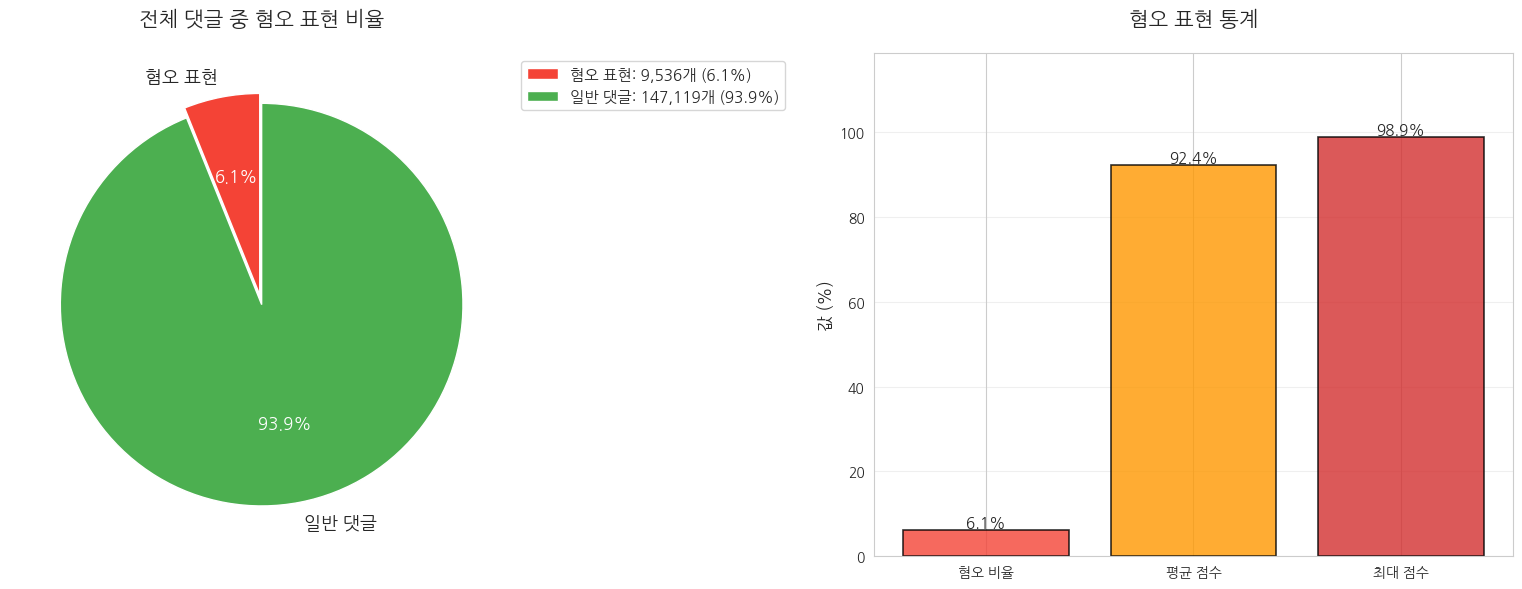

✓ 그래프 저장: output/figures/hatescore_overall_analysis.png


In [29]:
# 혐오 vs 비혐오 비율 (개선)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 파이 차트
labels = ['혐오 표현', '일반 댓글']
counts = [overall['hate_count'], overall['total_comments'] - overall['hate_count']]
colors = [HATE_COLORS['hate'], HATE_COLORS['normal']]

wedges, texts, autotexts = ax1.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 13, 'weight': 'bold'},
    explode=(0.05, 0)
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

ax1.set_title('전체 댓글 중 혐오 표현 비율', fontsize=15, weight='bold', pad=20)

# 범례
legend_labels = [f'{l}: {c:,}개 ({c/sum(counts)*100:.1f}%)' for l, c in zip(labels, counts)]
ax1.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

# 통계 정보 (막대)
stats_labels = ['혐오 비율', '평균 점수', '최대 점수']
stats_values = [
    overall['hate_ratio'] * 100,
    overall['avg_hate_score'] * 100,
    overall['max_hate_score'] * 100
]

bars = ax2.bar(stats_labels, stats_values, 
               color=[HATE_COLORS['hate'], HATE_COLORS['warning'], HATE_COLORS['danger']],
               alpha=0.8, edgecolor='black', linewidth=1.2)

# 값 레이블
for bar, val in zip(bars, stats_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}%' if val < 1 else f'{val:.1f}%',
             ha='center', va='bottom', fontsize=11, weight='bold')

ax2.set_ylabel('값 (%)', fontsize=12, weight='bold')
ax2.set_title('혐오 표현 통계', fontsize=15, weight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(stats_values) * 1.2)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_overall_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_overall_analysis.png")

## 3. 혐오 카테고리별 분석

/var/folders/hs/4lryff295n5bkz9tyr_tzlx80000gn/T/ipykernel_64644/1110419688.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



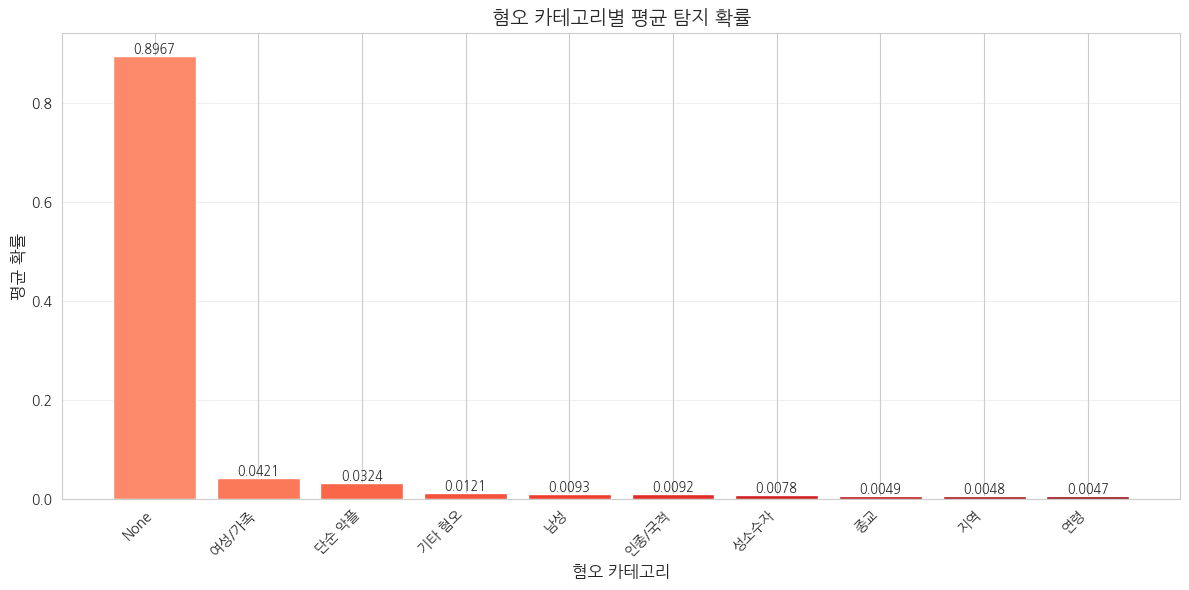

✓ 그래프 저장: output/figures/hatescore_category_probabilities.png


In [30]:
# 혐오 카테고리별 평균 확률
hate_categories = []
avg_probs = []

for key in overall.keys():
    if key.startswith('avg_prob_') and 'neutral' not in key.lower():
        category = key.replace('avg_prob_', '')
        hate_categories.append(category)
        avg_probs.append(overall[key])

# 정렬
sorted_indices = np.argsort(avg_probs)[::-1]
hate_categories = [hate_categories[i] for i in sorted_indices]
avg_probs = [avg_probs[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))

colors_gradient = plt.cm.Reds(np.linspace(0.4, 0.9, len(hate_categories)))
bars = ax.bar(hate_categories, avg_probs, color=colors_gradient)

ax.set_xlabel('혐오 카테고리', fontsize=12, weight='bold')
ax.set_ylabel('평균 확률', fontsize=12, weight='bold')
ax.set_title('혐오 카테고리별 평균 탐지 확률', fontsize=14, weight='bold')
ax.set_xticklabels(hate_categories, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_category_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_category_probabilities.png")

## 4. 프로그램별 혐오 표현 분석

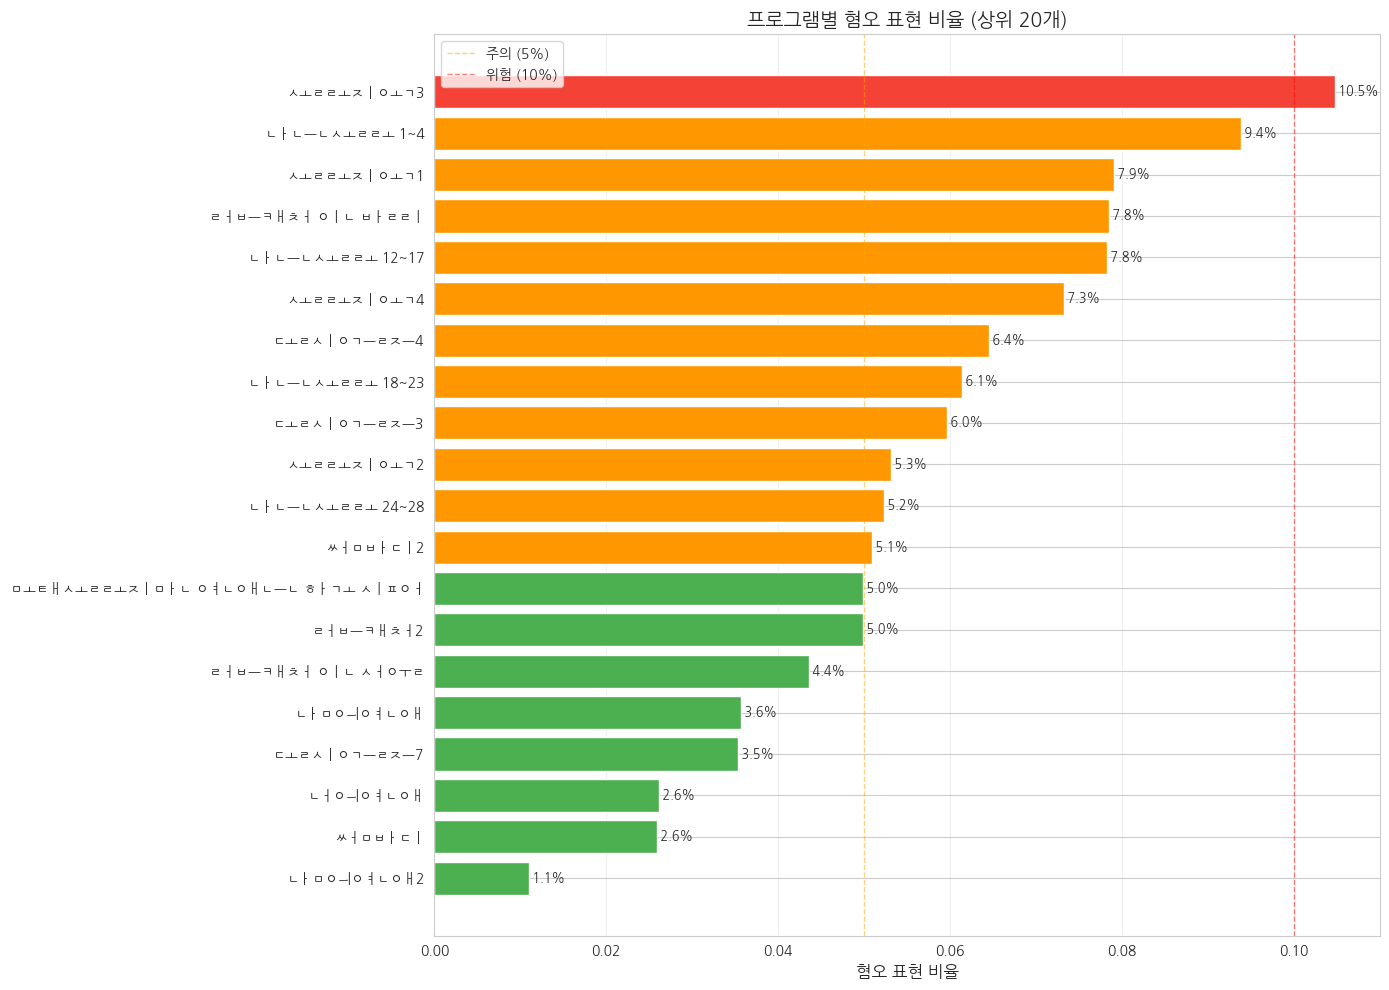

✓ 그래프 저장: output/figures/hatescore_program_hate_ratio.png


In [31]:
# 프로그램별 혐오 비율 (상위 20개)
top_20_programs = program_df.nlargest(20, 'total_comments').sort_values('avg_hate_ratio', ascending=True)

fig, ax = plt.subplots(figsize=(14, 10))

colors_hate = ['#F44336' if ratio > 0.1 else '#FF9800' if ratio > 0.05 else '#4CAF50' 
               for ratio in top_20_programs['avg_hate_ratio']]

bars = ax.barh(range(len(top_20_programs)), top_20_programs['avg_hate_ratio'], color=colors_hate)
ax.set_yticks(range(len(top_20_programs)))
ax.set_yticklabels(top_20_programs['program'])
ax.set_xlabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('프로그램별 혐오 표현 비율 (상위 20개)', fontsize=14, weight='bold')
ax.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='주의 (5%)')
ax.axvline(x=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='위험 (10%)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# 값 표시
for i, (idx, row) in enumerate(top_20_programs.iterrows()):
    ax.text(row['avg_hate_ratio'], i, f" {row['avg_hate_ratio']:.1%}",
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_program_hate_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_program_hate_ratio.png")

In [32]:
# 혐오 표현이 가장 많은 프로그램
print("=" * 70)
print("⚠️  혐오 표현 비율이 높은 프로그램 (상위 10개)")
print("=" * 70)
high_hate = program_df.nlargest(10, 'avg_hate_ratio')[['program', 'avg_hate_ratio', 'total_hate_count', 'total_comments']]
print(high_hate.to_string(index=False))
print()

# 혐오 표현이 가장 적은 프로그램
print("=" * 70)
print("✅ 혐오 표현 비율이 낮은 프로그램 (하위 10개)")
print("=" * 70)
low_hate = program_df.nsmallest(10, 'avg_hate_ratio')[['program', 'avg_hate_ratio', 'total_hate_count', 'total_comments']]
print(low_hate.to_string(index=False))

⚠️  혐오 표현 비율이 높은 프로그램 (상위 10개)
           program  avg_hate_ratio  total_hate_count  total_comments
   나는솔로 5~11        0.122031               114             878
 나대지마 심장아        0.118241                67             641
       솔로지옥3        0.104782              1191           10389
        비밀남녀        0.103997               253            1620
    나는솔로 1~4        0.093899               336            3443
  신들린 연애2        0.091874                71            1357
 누난 내게 여자야        0.083498               187            1685
       솔로지옥1        0.079051               818           10861
러브캐처 인 발리        0.078497               291            3422
  나는솔로 12~17        0.078259               372            5036

✅ 혐오 표현 비율이 낮은 프로그램 (하위 10개)
              program  avg_hate_ratio  total_hate_count  total_comments
 소년 소녀 연애하다        0.000000                 0              11
          남의연애2        0.01097

## 5. 동영상별 혐오 표현 편차

/var/folders/hs/4lryff295n5bkz9tyr_tzlx80000gn/T/ipykernel_64644/562629554.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



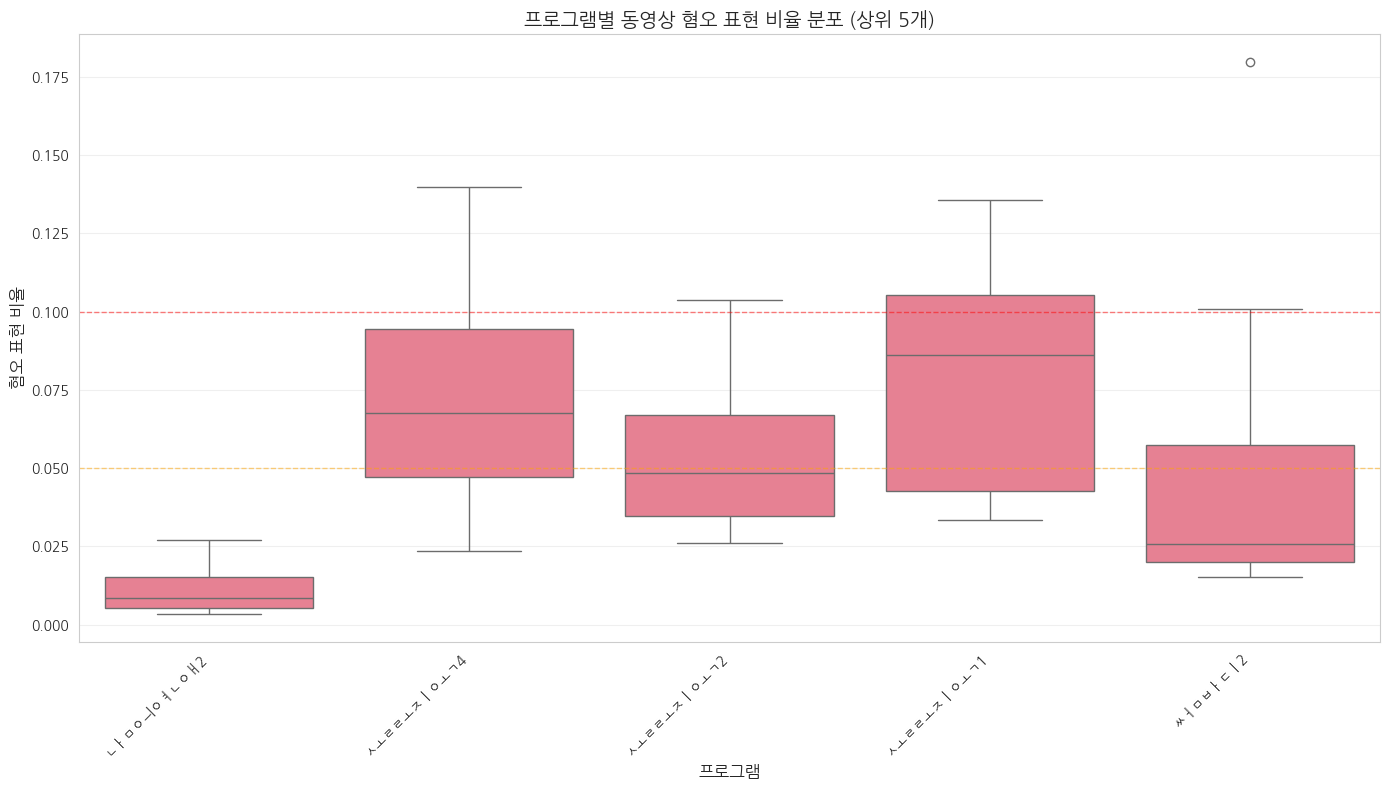

✓ 그래프 저장: output/figures/hatescore_video_boxplot.png


In [33]:
# 프로그램별 동영상 혐오 비율 분포 (박스플롯)
top_5_programs = program_df.nlargest(5, 'total_comments')['program'].tolist()
video_df_filtered = video_df[video_df['program'].isin(top_5_programs)]

fig, ax = plt.subplots(figsize=(14, 8))

sns.boxplot(data=video_df_filtered, x='program', y='hate_ratio', ax=ax)
ax.set_xlabel('프로그램', fontsize=12, weight='bold')
ax.set_ylabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('프로그램별 동영상 혐오 표현 비율 분포 (상위 5개)', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_video_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_video_boxplot.png")

## 7. 혐오 표현과 댓글 수의 관계

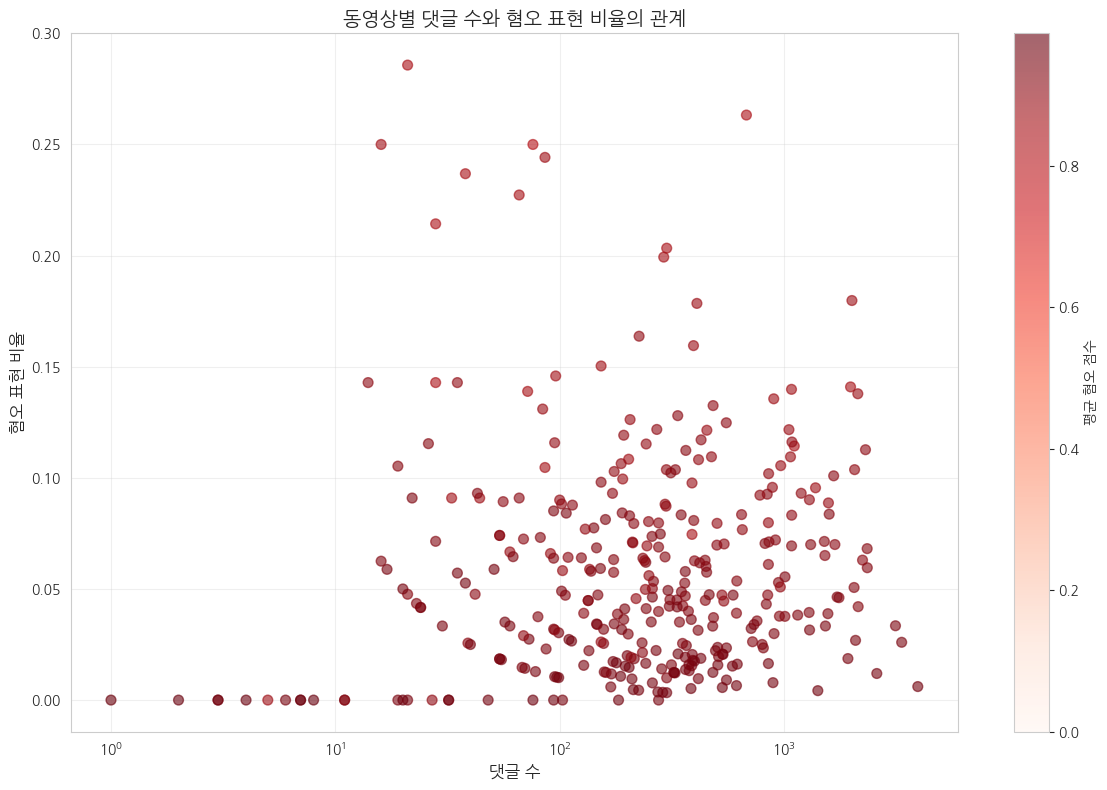

✓ 그래프 저장: output/figures/hatescore_comments_vs_ratio.png


In [34]:
# 산점도: 댓글 수 vs 혐오 비율
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    video_df['total_comments'],
    video_df['hate_ratio'],
    c=video_df['avg_hate_score'],
    cmap='Reds',
    alpha=0.6,
    s=50
)

ax.set_xlabel('댓글 수', fontsize=12, weight='bold')
ax.set_ylabel('혐오 표현 비율', fontsize=12, weight='bold')
ax.set_title('동영상별 댓글 수와 혐오 표현 비율의 관계', fontsize=14, weight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 컬러바
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('평균 혐오 점수', fontsize=10)

plt.tight_layout()
plt.savefig('../output/figures/hatescore_comments_vs_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_comments_vs_ratio.png")

In [35]:
# 상관관계 분석
correlation = video_df[['total_comments', 'hate_ratio', 'avg_hate_score']].corr()

print("=" * 70)
print("📊 상관관계 분석")
print("=" * 70)
print(correlation)
print()

# 해석
corr_comments_hate = correlation.loc['total_comments', 'hate_ratio']
if abs(corr_comments_hate) < 0.1:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 매우 약함 ({corr_comments_hate:.3f})")
elif abs(corr_comments_hate) < 0.3:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 약함 ({corr_comments_hate:.3f})")
else:
    print(f"💡 댓글 수와 혐오 비율 간 상관관계: 중간 이상 ({corr_comments_hate:.3f})")

📊 상관관계 분석
                total_comments  hate_ratio  avg_hate_score
total_comments        1.000000    0.044557        0.006818
hate_ratio            0.044557    1.000000       -0.351892
avg_hate_score        0.006818   -0.351892        1.000000

💡 댓글 수와 혐오 비율 간 상관관계: 매우 약함 (0.045)


## 9. 심화 분석

### 9.1 혐오 카테고리 간 상관관계 분석


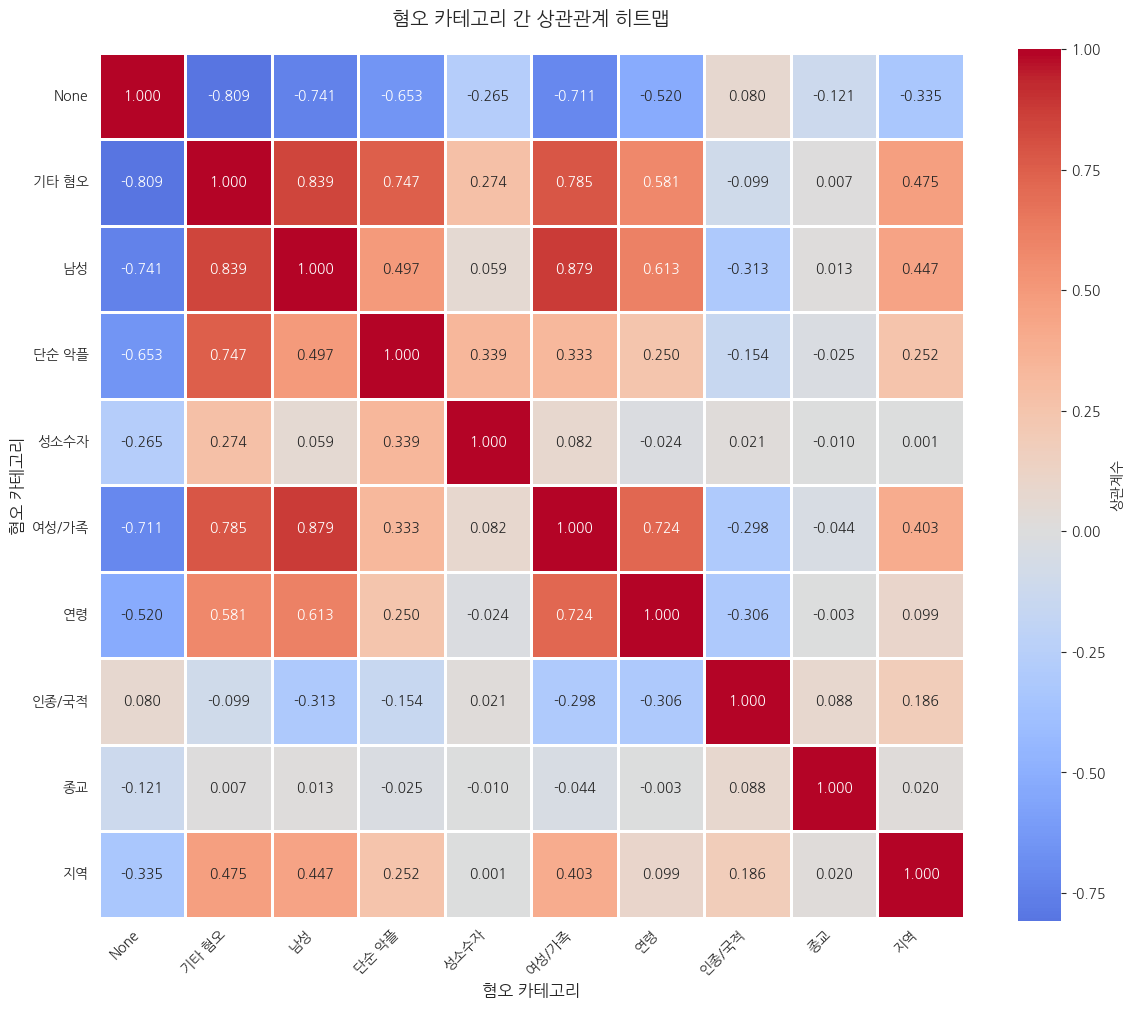

✓ 그래프 저장: output/figures/hatescore_category_correlation.png

📊 높은 상관관계를 보이는 카테고리 쌍 (상관계수 > 0.3)
  남성 ↔ 여성/가족: 0.879
  기타 혐오 ↔ 남성: 0.839
  None ↔ 기타 혐오: -0.809
  기타 혐오 ↔ 여성/가족: 0.785
  기타 혐오 ↔ 단순 악플: 0.747
  None ↔ 남성: -0.741
  여성/가족 ↔ 연령: 0.724
  None ↔ 여성/가족: -0.711
  None ↔ 단순 악플: -0.653
  남성 ↔ 연령: 0.613



In [36]:
# 혐오 카테고리 확률값 간 상관관계 분석
prob_cols = [col for col in program_df.columns if col.startswith('avg_prob_')]
category_names = [col.replace('avg_prob_', '') for col in prob_cols]

# 상관관계 계산
correlation_matrix = program_df[prob_cols].corr()
correlation_matrix.columns = category_names
correlation_matrix.index = category_names

# 시각화
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': '상관계수'},
    ax=ax,
    xticklabels=category_names,
    yticklabels=category_names
)

ax.set_title('혐오 카테고리 간 상관관계 히트맵', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('혐오 카테고리', fontsize=12, weight='bold')
ax.set_ylabel('혐오 카테고리', fontsize=12, weight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/figures/hatescore_category_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_category_correlation.png")
print()

# 높은 상관관계 쌍 식별
print("=" * 70)
print("📊 높은 상관관계를 보이는 카테고리 쌍 (상관계수 > 0.3)")
print("=" * 70)

high_corr_pairs = []
for i in range(len(category_names)):
    for j in range(i+1, len(category_names)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            high_corr_pairs.append((category_names[i], category_names[j], corr_val))

if high_corr_pairs:
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for cat1, cat2, corr in high_corr_pairs[:10]:
        print(f"  {cat1} ↔ {cat2}: {corr:.3f}")
else:
    print("  높은 상관관계를 보이는 카테고리 쌍이 없습니다.")
print()


### 9.2 혐오 카테고리별 프로그램 순위


📊 혐오 카테고리별 프로그램 순위 (상위 5개)

🔸 기타 혐오 카테고리:
          program  avg_prob_기타 혐오  total_comments
      솔로지옥3        0.016321           10389
  나는솔로 5~11        0.015481             878
나대지마 심장아        0.014691             641
      솔로지옥4        0.013636           12124
      솔로지옥1        0.013561           10861


🔸 남성 카테고리:
          program  avg_prob_남성  total_comments
   나는솔로 1~4     0.014799            3443
      솔로지옥3     0.014464           10389
누난 내게 여자야     0.013060            1685
  나는솔로 5~11     0.012623             878
       비밀남녀     0.012107            1620


🔸 단순 악플 카테고리:
          program  avg_prob_단순 악플  total_comments
나대지마 심장아        0.053665             641
      솔로지옥3        0.052331           10389
        러브캐처2        0.042735            4864
잠만 자는 사이        0.039123             415
  나는솔로 5~11        0.037878             878


🔸 성소수자 카테고리:
          program  avg_prob_성소수자

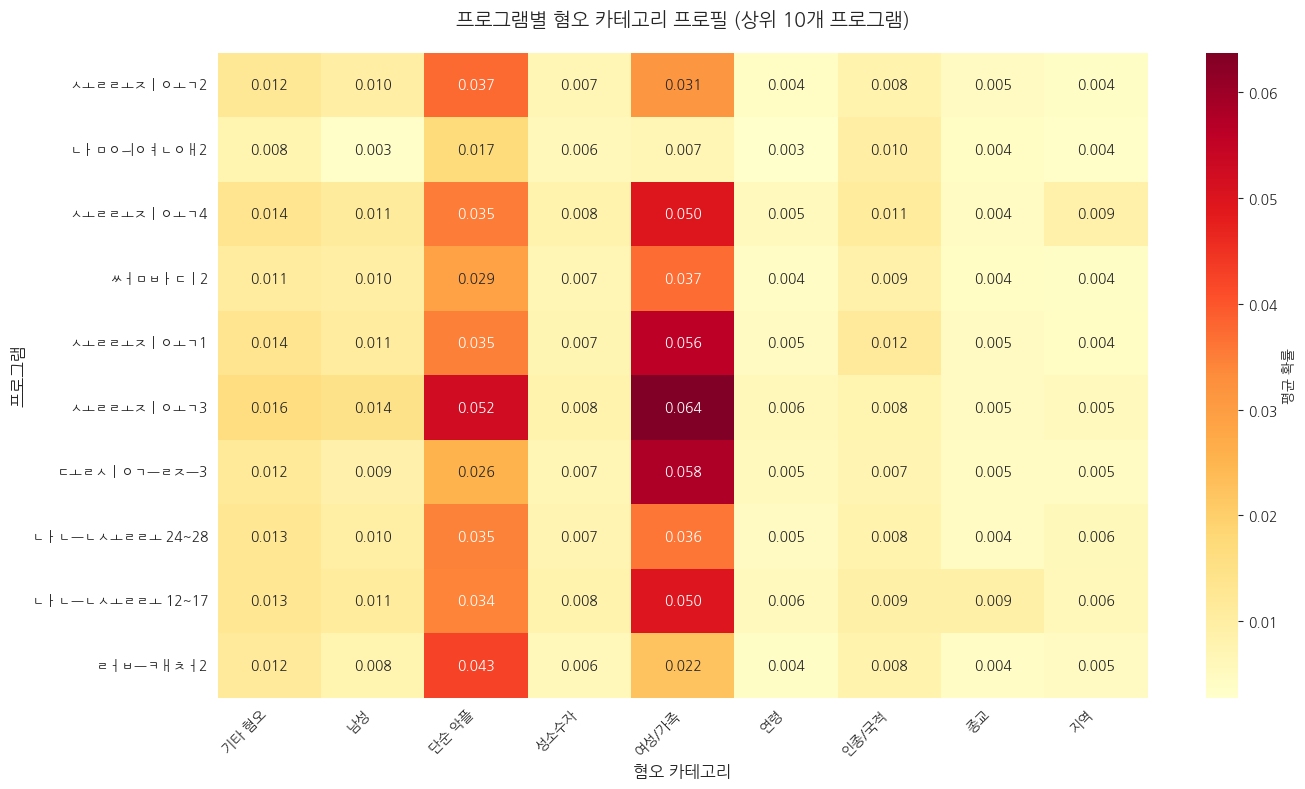

✓ 그래프 저장: output/figures/hatescore_program_category_profile.png


In [37]:
# 각 혐오 카테고리별로 평균 확률이 높은 프로그램 추출
hate_categories = [col.replace('avg_prob_', '') for col in prob_cols if col != 'avg_prob_None']

print("=" * 70)
print("📊 혐오 카테고리별 프로그램 순위 (상위 5개)")
print("=" * 70)

for category in hate_categories:
    prob_col = f'avg_prob_{category}'
    if prob_col in program_df.columns:
        top_programs = program_df.nlargest(5, prob_col)[['program', prob_col, 'total_comments']]
        print(f"\n🔸 {category} 카테고리:")
        print(top_programs.to_string(index=False))
        print()

# 프로그램별 혐오 카테고리 프로필 시각화
top_10_programs = program_df.nlargest(10, 'total_comments')

# 카테고리별 확률 데이터 준비 (None 제외)
category_data = []
for category in hate_categories:
    prob_col = f'avg_prob_{category}'
    if prob_col in top_10_programs.columns:
        category_data.append(top_10_programs[prob_col].values)

category_matrix = np.array(category_data).T

fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(
    category_matrix,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    xticklabels=hate_categories,
    yticklabels=top_10_programs['program'],
    cbar_kws={'label': '평균 확률'},
    ax=ax
)

ax.set_title('프로그램별 혐오 카테고리 프로필 (상위 10개 프로그램)', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('혐오 카테고리', fontsize=12, weight='bold')
ax.set_ylabel('프로그램', fontsize=12, weight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../output/figures/hatescore_program_category_profile.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 그래프 저장: output/figures/hatescore_program_category_profile.png")


### 9.3 혐오 점수와 메트릭 관계 분석


📊 메타데이터 로드 및 병합
✓ 메타데이터 병합 완료: 342개 동영상

📊 혐오 점수와 메트릭 간 상관관계 (수정된 분류 기준)
                hate_ratio  avg_hate_score
total_comments    0.044557        0.006818
Video Views       0.065864       -0.030184
Video Likes      -0.115203        0.159421
Video Dislikes         NaN             NaN
hate_ratio        1.000000       -0.351892
avg_hate_score   -0.351892        1.000000



/opt/anaconda3/envs/ds/lib/python3.10/site-packages/numpy/core/function_base.py:298: RuntimeWarning:

overflow encountered in power



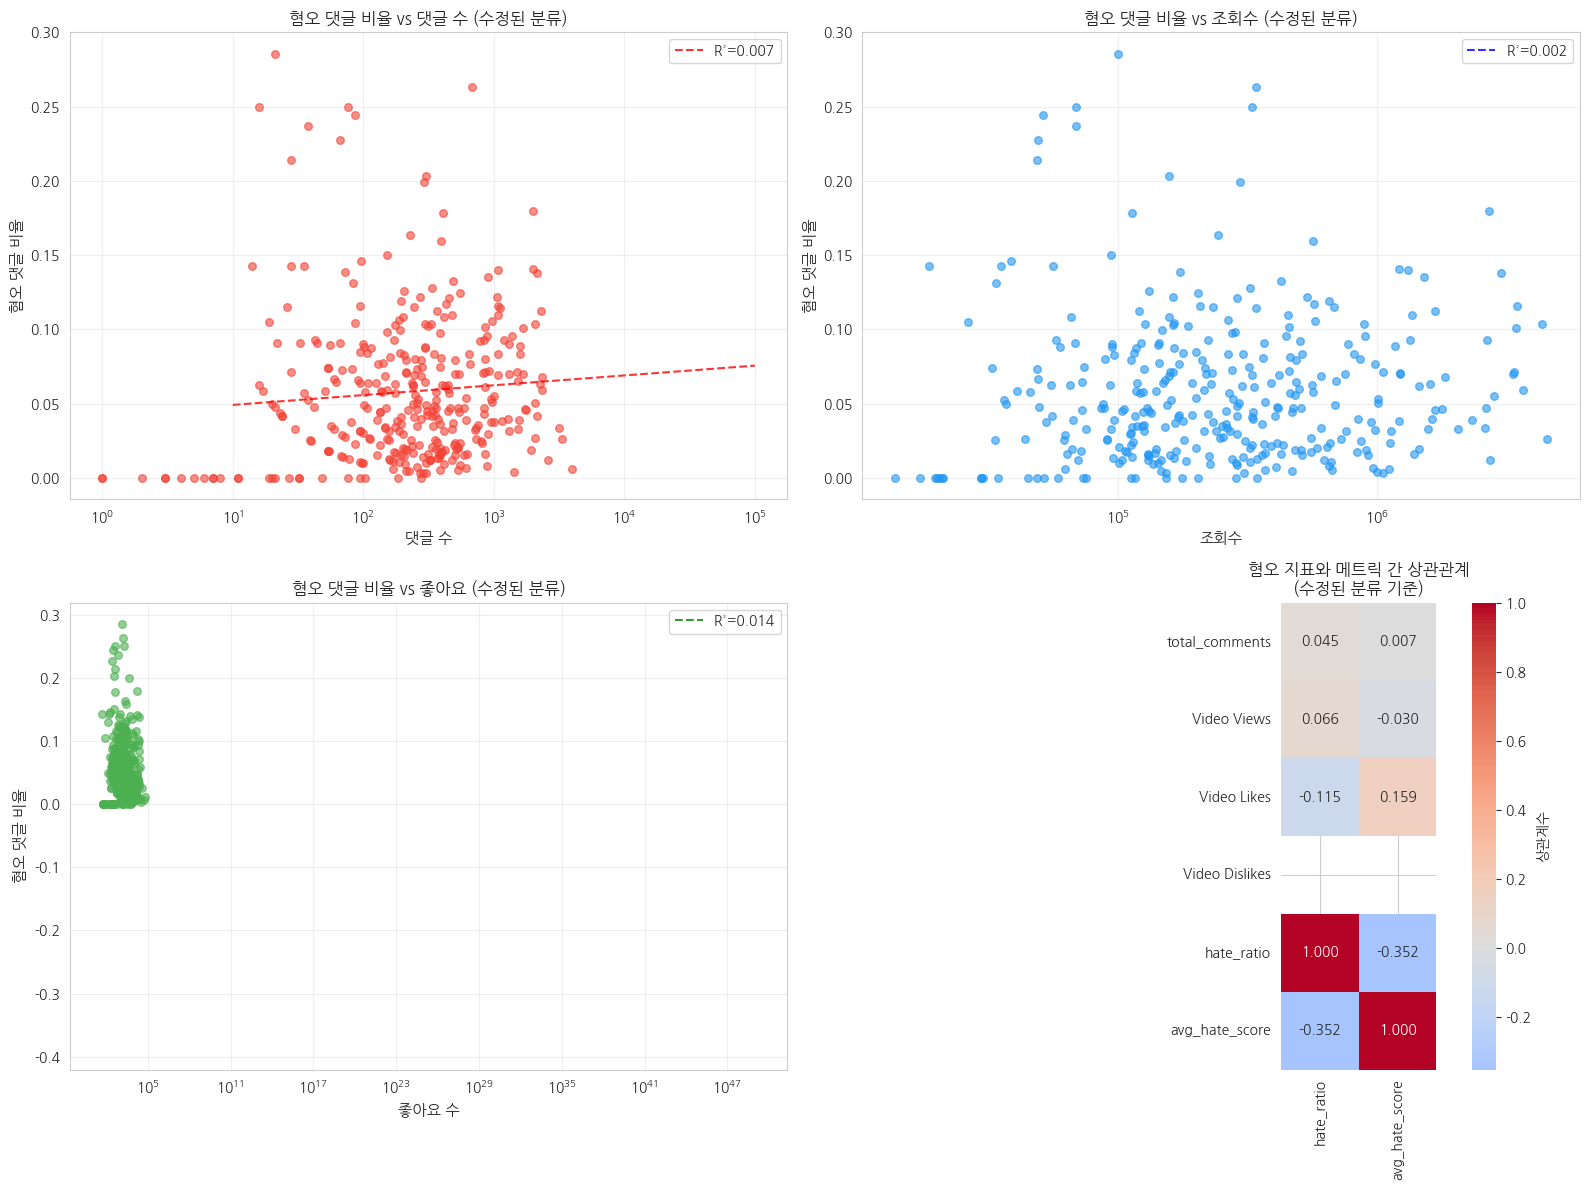

✓ 그래프 저장: output/figures/hatescore_metrics_correlation.png


In [38]:
# 메타데이터 로드 (조회수, 좋아요 등)
print("=" * 70)
print("📊 메타데이터 로드 및 병합")
print("=" * 70)

try:
    meta_df = pd.read_csv('../src/merged_comments.csv', 
                          usecols=['Video ID', 'Video Views', 'Video Likes', 'Video Dislikes'], 
                          encoding='utf-8')
    
    # 동영상별로 집계 (중복 제거)
    video_meta = meta_df.groupby('Video ID').agg({
        'Video Views': 'first',
        'Video Likes': 'first',
        'Video Dislikes': 'first'
    }).reset_index()
    
    # 수정된 video_df와 병합 (video_df는 이미 재계산되어 있음)
    video_df_enhanced = video_df.merge(video_meta, left_on='video_id', right_on='Video ID', how='left')
    print(f"✓ 메타데이터 병합 완료: {len(video_df_enhanced)}개 동영상")
    print()
    
    # 상관관계 분석
    metrics_cols = ['total_comments', 'Video Views', 'Video Likes', 'Video Dislikes', 
                    'hate_ratio', 'avg_hate_score']
    available_cols = [col for col in metrics_cols if col in video_df_enhanced.columns]
    
    correlation_metrics = video_df_enhanced[available_cols].corr()
    
    print("=" * 70)
    print("📊 혐오 점수와 메트릭 간 상관관계 (수정된 분류 기준)")
    print("=" * 70)
    print(correlation_metrics[['hate_ratio', 'avg_hate_score']])
    print()
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 혐오 비율 vs 댓글 수
    if 'total_comments' in video_df_enhanced.columns:
        axes[0, 0].scatter(video_df_enhanced['total_comments'], video_df_enhanced['hate_ratio'], 
                          alpha=0.6, s=30, color='#F44336')
        axes[0, 0].set_xlabel('댓글 수', fontsize=11, weight='bold')
        axes[0, 0].set_ylabel('혐오 댓글 비율', fontsize=11, weight='bold')
        axes[0, 0].set_title('혐오 댓글 비율 vs 댓글 수 (수정된 분류)', fontsize=12, weight='bold')
        axes[0, 0].set_xscale('log')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 회귀선 추가
        from scipy import stats
        mask = ~(np.isnan(video_df_enhanced['total_comments']) | np.isnan(video_df_enhanced['hate_ratio']))
        if mask.sum() > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                np.log10(video_df_enhanced.loc[mask, 'total_comments']),
                video_df_enhanced.loc[mask, 'hate_ratio']
            )
            x_line = np.logspace(1, 5, 100)
            y_line = slope * np.log10(x_line) + intercept
            axes[0, 0].plot(x_line, y_line, 'r--', alpha=0.8, label=f'R²={r_value**2:.3f}')
            axes[0, 0].legend()
    
    # 2. 혐오 비율 vs 조회수
    if 'Video Views' in video_df_enhanced.columns:
        mask = ~(video_df_enhanced['Video Views'].isna() | video_df_enhanced['hate_ratio'].isna())
        if mask.sum() > 0:
            axes[0, 1].scatter(video_df_enhanced.loc[mask, 'Video Views'], 
                              video_df_enhanced.loc[mask, 'hate_ratio'], 
                              alpha=0.6, s=30, color='#2196F3')
            axes[0, 1].set_xlabel('조회수', fontsize=11, weight='bold')
            axes[0, 1].set_ylabel('혐오 댓글 비율', fontsize=11, weight='bold')
            axes[0, 1].set_title('혐오 댓글 비율 vs 조회수 (수정된 분류)', fontsize=12, weight='bold')
            axes[0, 1].set_xscale('log')
            axes[0, 1].grid(True, alpha=0.3)
            
            # 회귀선 추가
            if mask.sum() > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    np.log10(video_df_enhanced.loc[mask, 'Video Views']),
                    video_df_enhanced.loc[mask, 'hate_ratio']
                )
                x_line = np.logspace(video_df_enhanced.loc[mask, 'Video Views'].min(), 
                                    video_df_enhanced.loc[mask, 'Video Views'].max(), 100)
                y_line = slope * np.log10(x_line) + intercept
                axes[0, 1].plot(x_line, y_line, 'b--', alpha=0.8, label=f'R²={r_value**2:.3f}')
                axes[0, 1].legend()
    
    # 3. 혐오 비율 vs 좋아요
    if 'Video Likes' in video_df_enhanced.columns:
        mask = ~(video_df_enhanced['Video Likes'].isna() | video_df_enhanced['hate_ratio'].isna())
        if mask.sum() > 0:
            axes[1, 0].scatter(video_df_enhanced.loc[mask, 'Video Likes'], 
                              video_df_enhanced.loc[mask, 'hate_ratio'], 
                              alpha=0.6, s=30, color='#4CAF50')
            axes[1, 0].set_xlabel('좋아요 수', fontsize=11, weight='bold')
            axes[1, 0].set_ylabel('혐오 댓글 비율', fontsize=11, weight='bold')
            axes[1, 0].set_title('혐오 댓글 비율 vs 좋아요 (수정된 분류)', fontsize=12, weight='bold')
            axes[1, 0].set_xscale('log')
            axes[1, 0].grid(True, alpha=0.3)
            
            # 회귀선 추가
            if mask.sum() > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    np.log10(video_df_enhanced.loc[mask, 'Video Likes']),
                    video_df_enhanced.loc[mask, 'hate_ratio']
                )
                x_line = np.logspace(video_df_enhanced.loc[mask, 'Video Likes'].min(), 
                                    video_df_enhanced.loc[mask, 'Video Likes'].max(), 100)
                y_line = slope * np.log10(x_line) + intercept
                axes[1, 0].plot(x_line, y_line, 'g--', alpha=0.8, label=f'R²={r_value**2:.3f}')
                axes[1, 0].legend()
    
    # 4. 상관관계 히트맵
    sns.heatmap(
        correlation_metrics[['hate_ratio', 'avg_hate_score']],
        annot=True,
        fmt='.3f',
        cmap='coolwarm',
        center=0,
        square=True,
        ax=axes[1, 1],
        cbar_kws={'label': '상관계수'}
    )
    axes[1, 1].set_title('혐오 지표와 메트릭 간 상관관계\n(수정된 분류 기준)', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.savefig('../output/figures/hatescore_metrics_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 그래프 저장: output/figures/hatescore_metrics_correlation.png")
    
except Exception as e:
    print(f"⚠ 메타데이터 로드 실패: {e}")
    print("  댓글 수와의 관계만 분석합니다.")
    print()
    
    # 댓글 수와의 관계만 분석 (수정된 video_df 사용)
    correlation_simple = video_df[['total_comments', 'hate_ratio', 'avg_hate_score']].corr()
    print("=" * 70)
    print("📊 혐오 점수와 댓글 수 간 상관관계 (수정된 분류 기준)")
    print("=" * 70)
    print(correlation_simple)
    print()

### 9.4 혐오 표현이 높은 동영상 샘플 분석


In [39]:
# 혐오 비율이 높은 동영상 상위 10개
print("=" * 70)
print("⚠️  혐오 비율이 높은 동영상 (상위 10개)")
print("=" * 70)

top_hate_ratio = video_df.nlargest(10, 'hate_ratio')[
    ['video_title', 'program', 'hate_ratio', 'hate_count', 'total_comments', 'avg_hate_score']
].copy()
top_hate_ratio['hate_ratio_pct'] = (top_hate_ratio['hate_ratio'] * 100).round(2)

print(top_hate_ratio[['video_title', 'program', 'hate_ratio_pct', 'hate_count', 'total_comments']].to_string(index=False))
print()

# 혐오 점수가 높은 동영상 상위 10개
print("=" * 70)
print("⚠️  혐오 점수가 높은 동영상 (상위 10개)")
print("=" * 70)

top_hate_score = video_df.nlargest(10, 'avg_hate_score')[
    ['video_title', 'program', 'avg_hate_score', 'hate_ratio', 'hate_count', 'total_comments']
].copy()
top_hate_score['hate_ratio_pct'] = (top_hate_score['hate_ratio'] * 100).round(2)

print(top_hate_score[['video_title', 'program', 'avg_hate_score', 'hate_ratio_pct', 'hate_count']].to_string(index=False))
print()

# 각 동영상의 카테고리별 분포 분석
print("=" * 70)
print("📊 상위 혐오 동영상의 카테고리별 분포 (혐오 비율 상위 5개)")
print("=" * 70)

top_5_videos = video_df.nlargest(5, 'hate_ratio')
for idx, row in top_5_videos.iterrows():
    print(f"\n🎬 {row['video_title']} ({row['program']})")
    print(f"   혐오 비율: {row['hate_ratio']:.1%}, 혐오 점수: {row['avg_hate_score']:.3f}")
    print("   카테고리별 평균 확률:")
    
    for category in hate_categories:
        prob_col = f'avg_prob_{category}'
        if prob_col in row.index and pd.notna(row[prob_col]):
            if row[prob_col] > 0.01:  # 1% 이상인 경우만 표시
                print(f"     - {category}: {row[prob_col]:.3f}")
print()


⚠️  혐오 비율이 높은 동영상 (상위 10개)
                                                      video_title           program  hate_ratio_pct  hate_count  total_comments
              직업 공개에서 등장한 검⚔ 귀신 잡는 퇴귀사 등장👻 #Shorts | 신들린 연애 | SBS  신들린 연애2           28.57           6              21
"시상식 온 줄 알았어~" 헤라의 등장과 함께 시작된 견제와 기싸움😱 [비밀남녀] | KBS Joy 220830 방송        비밀남녀           26.32         179             680
                          연애 프로그램에서 0표 받으면 생기는 일 #shorts #나대지마심장아 나대지마 심장아           25.00           4              16
                          딘딘이랑 조현영이 화해하는 방법ㅋㅋㅋㅋㅋ #shorts #나대지마심장아 나대지마 심장아           25.00          19              76
             [나는 SOLO] 깜짝 놀랄 솔로녀들의 자기소개! 예상 밖의 귀 호강까지?!! //ep5-11   나는솔로 5~11           24.42          21              86
             과거 평범한 은행원에서💵 무당이 될 수밖에 없던 여자 #Shorts | 신들린 연애 | SBS  신들린 연애2           23.68           9              38
         [나는 SOLO] 솔로녀들의 자기소개 시간! 드디어 공개되는 정순&정숙의 관계!!!  //ep5-10   나는솔ᄅ

### 9.5 혐오 카테고리 조합 분석


📊 혐오 카테고리 조합 분석
다중 카테고리를 가진 댓글 수: 3,203개 (2.0%)

📊 가장 빈번한 카테고리 조합 (상위 10개)
  단순 악플 + 여성/가족: 1,034개 (32.3%)
  남성 + 여성/가족: 832개 (26.0%)
  기타 혐오 + 단순 악플: 445개 (13.9%)
  남성 + 단순 악플: 426개 (13.3%)
  성소수자 + 여성/가족: 211개 (6.6%)
  기타 혐오 + 여성/가족: 209개 (6.5%)
  단순 악플 + 인종/국적: 170개 (5.3%)
  여성/가족 + 인종/국적: 163개 (5.1%)
  여성/가족 + 연령: 114개 (3.6%)
  단순 악플 + 연령: 92개 (2.9%)



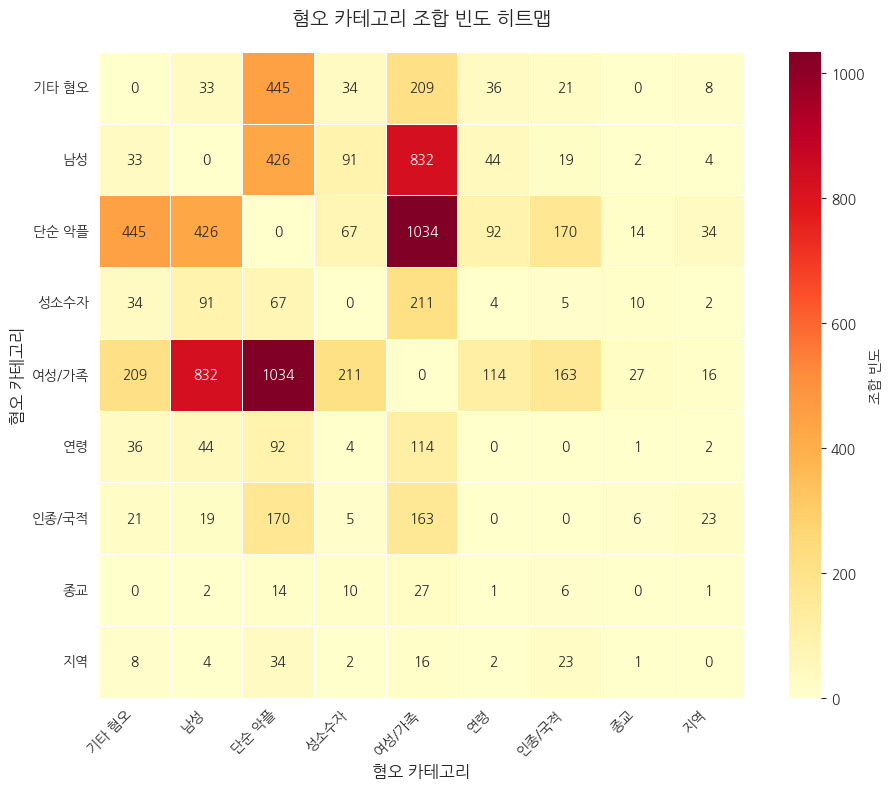

✓ 그래프 저장: output/figures/hatescore_category_combinations.png



In [40]:
# 다중 카테고리가 동시에 높은 확률을 보이는 댓글 분석
print("=" * 70)
print("📊 혐오 카테고리 조합 분석")
print("=" * 70)

# 댓글 데이터에서 카테고리 확률값 추출
hate_prob_cols = [col for col in comments_df.columns if col.startswith('hate_prob_') and col != 'hate_prob_None']
threshold = 0.1  # 10% 이상 확률을 가진 카테고리를 "높은 확률"로 간주

# 각 댓글에 대해 높은 확률을 가진 카테고리 추출
comments_df['high_prob_categories'] = comments_df[hate_prob_cols].apply(
    lambda row: [col.replace('hate_prob_', '') for col in hate_prob_cols 
                 if row[col] >= threshold], axis=1
)

# 다중 카테고리를 가진 댓글 필터링
multi_category_comments = comments_df[comments_df['high_prob_categories'].apply(len) > 1]
print(f"다중 카테고리를 가진 댓글 수: {len(multi_category_comments):,}개 ({len(multi_category_comments)/len(comments_df):.1%})")
print()

# 카테고리 조합 빈도 분석
from collections import Counter
from itertools import combinations

category_combinations = []
for categories in multi_category_comments['high_prob_categories']:
    if len(categories) >= 2:
        # 2개 조합 생성
        for combo in combinations(sorted(categories), 2):
            category_combinations.append(combo)

combo_counts = Counter(category_combinations)

print("=" * 70)
print("📊 가장 빈번한 카테고리 조합 (상위 10개)")
print("=" * 70)
for (cat1, cat2), count in combo_counts.most_common(10):
    ratio = count / len(multi_category_comments) * 100
    print(f"  {cat1} + {cat2}: {count:,}개 ({ratio:.1f}%)")
print()

# 조합 빈도 히트맵 생성
if len(combo_counts) > 0:
    # 카테고리 목록 추출
    all_categories = sorted(set([cat for combo in combo_counts.keys() for cat in combo]))
    
    # 조합 매트릭스 생성
    combo_matrix = pd.DataFrame(0, index=all_categories, columns=all_categories)
    for (cat1, cat2), count in combo_counts.items():
        combo_matrix.loc[cat1, cat2] = count
        combo_matrix.loc[cat2, cat1] = count  # 대칭 행렬
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        combo_matrix,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        square=True,
        linewidths=0.5,
        cbar_kws={'label': '조합 빈도'},
        ax=ax
    )
    
    ax.set_title('혐오 카테고리 조합 빈도 히트맵', fontsize=14, weight='bold', pad=20)
    ax.set_xlabel('혐오 카테고리', fontsize=12, weight='bold')
    ax.set_ylabel('혐오 카테고리', fontsize=12, weight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('../output/figures/hatescore_category_combinations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 그래프 저장: output/figures/hatescore_category_combinations.png")
else:
    print("⚠ 다중 카테고리 조합이 충분하지 않아 히트맵을 생성할 수 없습니다.")
print()


## 10. 인터랙티브 시각화 (Plotly)

### 10.1 프로그램별 혐오 카테고리 분포 (스택 바)


In [41]:
# Plotly 설정
pio.templates.default = "plotly_white"

# 프로그램별 혐오 카테고리 분포 데이터 준비
program_melted = program_df.melt(
    id_vars=['program'], 
    value_vars=[col for col in program_df.columns if col.startswith('avg_prob_') and col != 'avg_prob_None'],
    var_name='Category', 
    value_name='Probability'
)
program_melted['Category'] = program_melted['Category'].str.replace('avg_prob_', '')

# 색상 매핑 (혐오 카테고리별)
category_colors = {
    '여성/가족': '#DC143C',
    '단순 악플': '#FF4500',
    '남성': '#FF6347',
    '성소수자': '#8B0000',
    '인종/국적': '#B22222',
    '연령': '#CD5C5C',
    '지역': '#F08080',
    '종교': '#E9967A',
    '기타 혐오': '#FF7F50'
}

fig = px.bar(
    program_melted, 
    x='program', 
    y='Probability', 
    color='Category',
    title='<b>프로그램별 혐오 카테고리 분포</b> (Interactive Stacked Bar)',
    color_discrete_map=category_colors,
    hover_data={'Probability': ':.3f'},
    labels={'program': '프로그램', 'Probability': '평균 확률', 'Category': '혐오 카테고리'},
    height=600
)

fig.update_layout(
    xaxis_tickangle=-45,
    barmode='stack',
    legend_title_text='혐오 카테고리',
    width=1200
)

fig.show()
print("💡 인터랙티브 그래프: 확대/축소, 호버, 범례 클릭으로 카테고리 필터링 가능")


💡 인터랙티브 그래프: 확대/축소, 호버, 범례 클릭으로 카테고리 필터링 가능


### 10.2 시계열 추이 분석


In [42]:
# 업로드 일자 메타데이터 로드 및 병합
print("=" * 70)
print("📅 동영상 업로드 일자 메타데이터 로드")
print("=" * 70)

try:
    meta_df = pd.read_csv('../src/merged_comments.csv', 
                          usecols=['Video ID', 'Video Upload Date'], 
                          encoding='utf-8')
    
    video_dates = meta_df.drop_duplicates(subset=['Video ID']).rename(columns={
        'Video ID': 'video_id', 
        'Video Upload Date': 'upload_date'
    })
    
    video_dates['upload_date'] = pd.to_datetime(video_dates['upload_date'], errors='coerce')
    
    if 'upload_date' not in video_df.columns:
        video_df = video_df.merge(video_dates, on='video_id', how='left')
        print(f"✓ 날짜 정보 병합 완료: {len(video_df)}개 동영상")
    else:
        print("✓ 이미 날짜 정보가 포함되어 있습니다.")
    
    # 날짜 데이터가 있는 것만 필터링
    plot_df = video_df.dropna(subset=['upload_date']).sort_values('upload_date')
    
    if len(plot_df) > 0:
        # 전체 추이 (혐오 비율)
        fig1 = px.scatter(
            plot_df, 
            x='upload_date', 
            y='hate_ratio', 
            color='program', 
            size='total_comments',
            hover_data=['video_title', 'avg_hate_score'],
            title='<b>시간 흐름에 따른 혐오 표현 비율 추이</b>',
            labels={
                'upload_date': '업로드 일자',
                'hate_ratio': '혐오 표현 비율',
                'total_comments': '댓글 수',
                'program': '프로그램'
            },
            height=600
        )
        
        # 이동평균선 추가
        plot_df['trend'] = plot_df['hate_ratio'].rolling(window=10, min_periods=1).mean()
        fig1.add_trace(
            go.Scatter(
                x=plot_df['upload_date'],
                y=plot_df['trend'],
                mode='lines',
                name='전체 추세 (MA=10)',
                line=dict(color='black', width=3, dash='solid')
            )
        )
        
        fig1.update_xaxes(tickformat="%Y-%m-%d")
        fig1.add_hline(y=0.05, line_dash="dash", line_color="orange", annotation_text="주의 (5%)")
        fig1.add_hline(y=0.1, line_dash="dash", line_color="red", annotation_text="위험 (10%)")
        fig1.show()
        
        # 전체 추이 (혐오 점수)
        fig2 = px.scatter(
            plot_df, 
            x='upload_date', 
            y='avg_hate_score', 
            color='program', 
            size='total_comments',
            hover_data=['video_title', 'hate_ratio'],
            title='<b>시간 흐름에 따른 혐오 점수 추이</b>',
            labels={
                'upload_date': '업로드 일자',
                'avg_hate_score': '평균 혐오 점수',
                'total_comments': '댓글 수',
                'program': '프로그램'
            },
            height=600
        )
        
        # 이동평균선 추가
        plot_df['trend_score'] = plot_df['avg_hate_score'].rolling(window=10, min_periods=1).mean()
        fig2.add_trace(
            go.Scatter(
                x=plot_df['upload_date'],
                y=plot_df['trend_score'],
                mode='lines',
                name='전체 추세 (MA=10)',
                line=dict(color='black', width=3, dash='solid')
            )
        )
        
        fig2.update_xaxes(tickformat="%Y-%m-%d")
        fig2.show()
        
        print("💡 인터랙티브 그래프: 시간대별 필터링, 확대/축소 가능")
    else:
        print("⚠ 날짜 데이터가 없어 시계열 그래프를 생성할 수 없습니다.")
        
except Exception as e:
    print(f"⚠ 날짜 정보 로드 실패: {e}")
    print("  시계열 분석을 건너뜁니다.")
print()


📅 동영상 업로드 일자 메타데이터 로드
✓ 날짜 정보 병합 완료: 342개 동영상


💡 인터랙티브 그래프: 시간대별 필터링, 확대/축소 가능



### 10.3 프로그램별 상세 추이


In [43]:
# 프로그램별 상세 추이 분석
if 'upload_date' in video_df.columns:
    programs = sorted(video_df['program'].unique())
    program_figures = []
    
    for prog in programs:
        prog_df = video_df[video_df['program'] == prog].dropna(subset=['upload_date']).sort_values('upload_date')
        
        if len(prog_df) < 3:  # 데이터가 너무 적으면 건너뛰기
            continue
        
        # 이동평균 계산
        window_size = max(3, int(len(prog_df) * 0.2))
        prog_df['trend'] = prog_df['hate_ratio'].rolling(window=window_size, min_periods=1).mean()
        
        fig_p = px.scatter(
            prog_df, 
            x='upload_date', 
            y='hate_ratio', 
            size='total_comments', 
            hover_data=['video_title', 'avg_hate_score'],
            title=f"<b>{prog}</b>: 혐오 표현 비율 변화 추이",
            labels={
                'upload_date': '업로드 일자', 
                'hate_ratio': '혐오 표현 비율',
                'total_comments': '댓글 수'
            },
            height=500
        )
        
        # 추세선 추가
        fig_p.add_trace(
            go.Scatter(
                x=prog_df['upload_date'],
                y=prog_df['trend'],
                mode='lines',
                name=f'추세선 (MA={window_size})',
                line=dict(color='red', width=2, dash='solid')
            )
        )
        
        fig_p.update_xaxes(tickformat="%Y-%m-%d")
        fig_p.add_hline(y=0.05, line_dash="dash", line_color="orange")
        fig_p.add_hline(y=0.1, line_dash="dash", line_color="red")
        fig_p.show()
        
        program_figures.append(fig_p)
    
    print(f"✓ {len(program_figures)}개 프로그램의 상세 추이 그래프 생성 완료")
    print("💡 각 프로그램별로 시간에 따른 혐오 패턴 변화를 확인할 수 있습니다.")
else:
    print("⚠ 날짜 정보가 없어 프로그램별 상세 추이를 생성할 수 없습니다.")
print()


✓ 35개 프로그램의 상세 추이 그래프 생성 완료
💡 각 프로그램별로 시간에 따른 혐오 패턴 변화를 확인할 수 있습니다.



### 10.4 동영상별 혐오 카테고리 분포 (닷플롯)


In [44]:
# 동영상별 혐오 점수 분포 (프로그램별)
fig = px.strip(
    video_df, 
    x="program", 
    y="avg_hate_score", 
    color="program", 
    hover_data=["video_title", "total_comments", "hate_ratio"],
    title="<b>프로그램별 동영상 혐오 점수 분포</b> (Interactive Dot Plot)",
    labels={
        "avg_hate_score": "평균 혐오 점수 (Hate Score)", 
        "program": "프로그램"
    },
    height=600
)

fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False,
    title_font_size=20,
    width=1200
)

fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

fig.show()
print("💡 인터랙티브 닷플롯: 각 점에 마우스를 올리면 동영상 정보 확인 가능")
print()


💡 인터랙티브 닷플롯: 각 점에 마우스를 올리면 동영상 정보 확인 가능



### 10.5 혐오 타입별 상세 분석 (카테고리별 색상 구분)


In [45]:
# 혐오 카테고리별 색상 매핑 (각 타입별로 구분되는 색상)
HATE_CATEGORY_COLORS = {
    'None': '#90EE90',           # 연한 초록 (비혐오)
    '여성/가족': '#DC143C',       # 진한 빨강
    '단순 악플': '#FF4500',       # 오렌지 레드
    '남성': '#FF6347',            # 토마토
    '성소수자': '#8B0000',        # 진한 빨강
    '인종/국적': '#B22222',       # 불타는 벽돌색
    '연령': '#CD5C5C',            # 인디언 레드
    '지역': '#F08080',            # 연한 산호색
    '종교': '#E9967A',            # 다크 살몬
    '기타 혐오': '#FF7F50'        # 산호색
}

# 혐오 카테고리 목록 (None 제외)
hate_categories_list = [cat for cat in HATE_CATEGORY_COLORS.keys() if cat != 'None']

print("=" * 70)
print("🎨 혐오 카테고리별 개별 인터랙티브 시각화")
print("=" * 70)
print(f"총 {len(hate_categories_list)}개 혐오 카테고리별로 개별 플롯 생성")
print()

# 각 혐오 카테고리별로 개별 플롯 생성
for category in hate_categories_list:
    prob_col = f'avg_prob_{category}'
    category_color = HATE_CATEGORY_COLORS.get(category, '#808080')
    
    print("=" * 70)
    print(f"📊 [{category}] 카테고리 분석")
    print("=" * 70)
    
    # 1. 프로그램별 분포 (상위 20개) - 해당 카테고리 색상만 사용
    if prob_col in program_df.columns:
        top_20_programs = program_df.nlargest(20, 'total_comments').sort_values(prob_col, ascending=True)
        
        fig1 = go.Figure()
        
        fig1.add_trace(go.Bar(
            x=top_20_programs[prob_col],
            y=top_20_programs['program'],
            orientation='h',
            marker=dict(
                color=category_color,
                opacity=0.8,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            text=[f'{val:.4f}' for val in top_20_programs[prob_col]],
            textposition='outside',
            hovertemplate='<b>%{y}</b><br>확률: %{x:.4f}<br>총 댓글: %{customdata[0]:,}개<br>혐오 비율: %{customdata[1]:.2%}<extra></extra>',
            customdata=top_20_programs[['total_comments', 'avg_hate_ratio']].values
        ))
        
        fig1.update_layout(
            title=f'<b>[{category}] 프로그램별 평균 확률</b> (상위 20개 프로그램)',
            xaxis_title='평균 확률',
            yaxis_title='프로그램',
            height=600,
            width=1000,
            hovermode='closest',
            plot_bgcolor='white'
        )
        
        fig1.show()
        print(f"✓ [{category}] 프로그램별 분포 그래프 생성")
        print()
    
    # 2. 동영상별 분포 (상위 30개) - 해당 카테고리 색상만 사용
    if prob_col in video_df.columns:
        top_30_videos = video_df.nlargest(30, 'total_comments')
        
        fig2 = go.Figure()
        
        fig2.add_trace(go.Scatter(
            x=top_30_videos['hate_ratio'],
            y=top_30_videos[prob_col],
            mode='markers',
            marker=dict(
                size=top_30_videos['total_comments'] / 10,
                color=category_color,
                opacity=0.7,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            text=top_30_videos['video_title'],
            hovertemplate='<b>%{text}</b><br>프로그램: %{customdata[0]}<br>{category} 확률: %{y:.4f}<br>혐오 비율: %{x:.2%}<br>혐오 점수: %{customdata[1]:.3f}<extra></extra>',
            customdata=top_30_videos[['program', 'avg_hate_score']].values
        ))
        
        fig2.update_layout(
            title=f'<b>[{category}] 동영상별 확률 분포</b> (상위 30개 동영상)',
            xaxis_title='혐오 표현 비율',
            yaxis_title=f'{category} 확률',
            height=600,
            width=1000,
            hovermode='closest',
            plot_bgcolor='white'
        )
        
        fig2.show()
        print(f"✓ [{category}] 동영상별 분포 그래프 생성")
        print()
    
    # 3. 시간에 따른 추이 - 해당 카테고리 색상만 사용
    if 'upload_date' in video_df.columns and prob_col in video_df.columns:
        ts_df = video_df.dropna(subset=['upload_date', prob_col]).sort_values('upload_date')
        
        if len(ts_df) > 0:
            fig3 = go.Figure()
            
            # 산점도
            fig3.add_trace(go.Scatter(
                x=ts_df['upload_date'],
                y=ts_df[prob_col],
                mode='markers',
                marker=dict(
                    size=ts_df['total_comments'] / 20,
                    color=category_color,
                    opacity=0.6,
                    line=dict(width=1, color='DarkSlateGrey')
                ),
                text=ts_df['video_title'],
                name='데이터 포인트',
                hovertemplate='<b>%{text}</b><br>프로그램: %{customdata[0]}<br>{category} 확률: %{y:.4f}<br>혐오 비율: %{customdata[1]:.2%}<extra></extra>',
                customdata=ts_df[['program', 'hate_ratio']].values
            ))
            
            # 추세선 추가
            if len(ts_df) > 1:
                window = max(5, int(len(ts_df) * 0.1))
                ts_df['trend'] = ts_df[prob_col].rolling(window=window, min_periods=1).mean()
                
                fig3.add_trace(go.Scatter(
                    x=ts_df['upload_date'],
                    y=ts_df['trend'],
                    mode='lines',
                    name='추세선',
                    line=dict(color=category_color, width=3, dash='solid'),
                    opacity=0.8,
                    hoverinfo='skip'
                ))
            
            fig3.update_layout(
                title=f'<b>[{category}] 시간에 따른 추이</b>',
                xaxis_title='업로드 일자',
                yaxis_title=f'{category} 확률',
                height=600,
                width=1200,
                hovermode='closest',
                plot_bgcolor='white',
                xaxis=dict(tickformat='%Y-%m-%d')
            )
            
            fig3.show()
            print(f"✓ [{category}] 시계열 추이 그래프 생성")
            print()
    
    # 4. 통계 정보
    if prob_col in program_df.columns:
        avg_prob = program_df[prob_col].mean()
        max_prob = program_df[prob_col].max()
        max_program = program_df.loc[program_df[prob_col].idxmax(), 'program']
        
        category_comments = comments_df[comments_df['hate_dominant_category'] == category]
        comment_count = len(category_comments)
        comment_ratio = comment_count / len(comments_df) if len(comments_df) > 0 else 0
        
        print(f"  평균 확률: {avg_prob:.4f}")
        print(f"  최대 확률: {max_prob:.4f} ({max_program})")
        print(f"  댓글 수: {comment_count:,}개 ({comment_ratio:.2%})")
        print()

print("=" * 70)
print("✅ 혐오 카테고리별 개별 인터랙티브 시각화 완료!")
print("=" * 70)
print("💡 각 카테고리별로 개별 플롯이 생성되었습니다.")
print("💡 마우스를 올리면 상세 정보를 확인할 수 있습니다.")
print()


🎨 혐오 카테고리별 개별 인터랙티브 시각화
총 9개 혐오 카테고리별로 개별 플롯 생성

📊 [여성/가족] 카테고리 분석


✓ [여성/가족] 프로그램별 분포 그래프 생성



✓ [여성/가족] 동영상별 분포 그래프 생성



✓ [여성/가족] 시계열 추이 그래프 생성

  평균 확률: 0.0401
  최대 확률: 0.0867 (비밀남녀)
  댓글 수: 4,749개 (3.03%)

📊 [단순 악플] 카테고리 분석


✓ [단순 악플] 프로그램별 분포 그래프 생성



✓ [단순 악플] 동영상별 분포 그래프 생성



✓ [단순 악플] 시계열 추이 그래프 생성

  평균 확률: 0.0286
  최대 확률: 0.0537 (나대지마 심장아)
  댓글 수: 3,265개 (2.08%)

📊 [남성] 카테고리 분석


✓ [남성] 프로그램별 분포 그래프 생성



✓ [남성] 동영상별 분포 그래프 생성



✓ [남성] 시계열 추이 그래프 생성

  평균 확률: 0.0084
  최대 확률: 0.0148 (나는솔로 1~4)
  댓글 수: 595개 (0.38%)

📊 [성소수자] 카테고리 분석


✓ [성소수자] 프로그램별 분포 그래프 생성



✓ [성소수자] 동영상별 분포 그래프 생성



✓ [성소수자] 시계열 추이 그래프 생성

  평균 확률: 0.0081
  최대 확률: 0.0274 (나대지마 심장아)
  댓글 수: 275개 (0.18%)

📊 [인종/국적] 카테고리 분석


✓ [인종/국적] 프로그램별 분포 그래프 생성



✓ [인종/국적] 동영상별 분포 그래프 생성



✓ [인종/국적] 시계열 추이 그래프 생성

  평균 확률: 0.0091
  최대 확률: 0.0150 (남의연애3)
  댓글 수: 245개 (0.16%)

📊 [연령] 카테고리 분석


✓ [연령] 프로그램별 분포 그래프 생성



✓ [연령] 동영상별 분포 그래프 생성



✓ [연령] 시계열 추이 그래프 생성

  평균 확률: 0.0048
  최대 확률: 0.0129 (나는솔로 5~11)
  댓글 수: 171개 (0.11%)

📊 [지역] 카테고리 분석


✓ [지역] 프로그램별 분포 그래프 생성



✓ [지역] 동영상별 분포 그래프 생성



✓ [지역] 시계열 추이 그래프 생성

  평균 확률: 0.0047
  최대 확률: 0.0089 (솔로지옥4)
  댓글 수: 145개 (0.09%)

📊 [종교] 카테고리 분석


✓ [종교] 프로그램별 분포 그래프 생성



✓ [종교] 동영상별 분포 그래프 생성



✓ [종교] 시계열 추이 그래프 생성

  평균 확률: 0.0060
  최대 확률: 0.0407 (신들린 연애2)
  댓글 수: 69개 (0.04%)

📊 [기타 혐오] 카테고리 분석


✓ [기타 혐오] 프로그램별 분포 그래프 생성



✓ [기타 혐오] 동영상별 분포 그래프 생성



✓ [기타 혐오] 시계열 추이 그래프 생성

  평균 확률: 0.0114
  최대 확률: 0.0163 (솔로지옥3)
  댓글 수: 22개 (0.01%)

✅ 혐오 카테고리별 개별 인터랙티브 시각화 완료!
💡 각 카테고리별로 개별 플롯이 생성되었습니다.
💡 마우스를 올리면 상세 정보를 확인할 수 있습니다.



## 11. HTML 대시보드 생성


In [46]:
# HTML 대시보드 생성
print("=" * 70)
print("📊 HTML 대시보드 생성")
print("=" * 70)

import sys
from pathlib import Path

# 대시보드 생성 스크립트 경로 추가
sys.path.append(str(Path('../visualization').resolve()))

try:
    from generate_hatescore_dashboard import generate_dashboard
    
    # 작업 디렉토리를 프로젝트 루트로 변경
    import os
    original_cwd = os.getcwd()
    os.chdir('../')
    
    generate_dashboard()
    
    # 원래 디렉토리로 복귀
    os.chdir(original_cwd)
    
    print()
    print("=" * 70)
    print("✅ 대시보드 생성 완료!")
    print("=" * 70)
    print("📁 저장 위치: output/reports/hatescore_dashboard.html")
    print("💡 웹 브라우저에서 열어 인터랙티브 그래프를 확인하세요.")
    
except Exception as e:
    print(f"⚠ 대시보드 생성 실패: {e}")
    print("  수동으로 실행하려면:")
    print("  python visualization/generate_hatescore_dashboard.py")
print()


📊 HTML 대시보드 생성
Generating HTML Dashboard for HateScore Hate Speech Analysis
✓ Loaded program summary from output/results/hatescore/program_summary_hatescore.csv
✓ Loaded video summary from output/results/hatescore/video_summary_hatescore.csv
✓ Loaded metadata from src/merged_comments.csv
✓ Merged upload dates

Generating individual category plots...
  ✓ 여성/가족 카테고리: 3개 플롯 생성
  ✓ 단순 악플 카테고리: 3개 플롯 생성
  ✓ 남성 카테고리: 3개 플롯 생성
  ✓ 성소수자 카테고리: 3개 플롯 생성
  ✓ 인종/국적 카테고리: 3개 플롯 생성
  ✓ 연령 카테고리: 3개 플롯 생성
  ✓ 지역 카테고리: 3개 플롯 생성
  ✓ 종교 카테고리: 3개 플롯 생성
  ✓ 기타 혐오 카테고리: 3개 플롯 생성

✅ Dashboard saved to: output/reports/hatescore_dashboard.html
   Includes 35 individual program plots.
   Includes 9 categories with individual plots.
   Total category plots: 27
   Open this file in your web browser to view interactive plots.

✅ 대시보드 생성 완료!
📁 저장 위치: output/reports/hatescore_dashboard.html
💡 웹 브라우저에서 열어 인터랙티브 그래프를 확인하세요.



## 12. 결론

### HateScore 혐오 표현 분석 요약

1. **전체 혐오 표현 현황**
   - 전체 댓글 중 혐오 표현 비율 파악
   - 평균 혐오 점수 및 분포 확인

2. **프로그램별 차이**
   - 프로그램마다 혐오 표현 비율에 큰 차이 존재
   - 특정 프로그램은 지속적으로 높은 혐오 비율
   - 콘텐츠 특성과 시청자 층의 영향 가능성

3. **혐오 카테고리 분석**
   - 특정 카테고리의 혐오 표현이 더 빈번
   - 연애 클립 특성상 성별 관련 혐오 가능성

4. **댓글 수와의 관계**
   - 댓글 수와 혐오 비율 간 상관관계 분석
   - 인기도와 혐오 표현의 관계 파악

5. **시사점**
   - 혐오 표현 모니터링 필요성
   - 커뮤니티 가이드라인 강화 필요
   - 특정 프로그램/동영상에 대한 집중 관리 필요